In [2]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx as ox # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
from shapely.geometry import Polygon
import numpy as np
import pandana 
import os
from tqdm import tqdm

In [4]:
#amenities_with_neighborhood.to_file("amenities_with_neighborhood.geojson", driver='GeoJSON')
# amenities_with_neighborhood = gpd.read_file('/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/dataframes/amenities_with_neighborhood.geojson')

# absolute path
amenities_with_neighborhood = gpd.read_file('../dataframes/amenities_with_neighborhood.geojson')

In [5]:
neighbourhoods = list(amenities_with_neighborhood['Arrondissement'].unique())[:-1]
neighbourhoods = [neighborhood + ', Montreal, Canada' for neighborhood in neighbourhoods]

In [6]:
place = 'Montreal, Canada'
# Get all the "fresh food" stores on OSM within the study site
tags = {'amenity': ['restaurant', 'cafe']}
amenities = ox.features_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')
# Some amenities might be polygons, but we need them as points, so let's extract the centroids from the amenities' geometries
centroids = amenities.centroid

In [11]:
# # RUN ONLY ONCE TO SAVE THE GRAPHS - ALREADY DONE

# graphs = {}

# # specify parameters for the analysis
# walk_time = 15  # max walking horizon in minutes
# walk_speed = 5  # km per hour
# walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# # Loop through the neighborhoods
# for neighborhood in tqdm(neighbourhoods):
#     # Create a graph for the current neighborhood
#     G_walk_neighborhood = ox.graph_from_place(neighborhood, network_type='walk') # type of transportation is set here

#     for u, v, data in G_walk_neighborhood.edges(data=True):
#         data['speed_kph'] = walk_speed
#     G_walk_neighborhood = ox.add_edge_travel_times(G_walk_neighborhood) # this computes the travel time in seconds based on the 'speed_kph' column

# # caro path
#     # ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
# # michel path
#     ox.save_graphml(G_walk_neighborhood, f"../graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
#     # Store the graph in the dictionary using the neighborhood name as the key
#     graphs[neighborhood] = G_walk_neighborhood

 11%|█         | 2/18 [00:46<06:09, 23.10s/it]


KeyboardInterrupt: 

In [12]:
graphs = {}
# graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs'
graphs_dir = '../graphs'

if graphs == {}:
    for file_name in tqdm(os.listdir(graphs_dir)):
        if file_name.endswith(".graphml"):
            neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
            file_path = os.path.join(graphs_dir, file_name)
            G_walk_neighborhood = ox.load_graphml(file_path)
            graphs[neighborhood] = G_walk_neighborhood

100%|██████████| 18/18 [00:32<00:00,  1.80s/it]


In [53]:
pandanas = {}

if pandanas == {}:
    # Build Pandana network for each neighborhood
    for neighborhood, graph in tqdm(graphs.items()):
        graph = ox.project_graph(graph, to_crs='EPSG:25832')
        nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
        edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

        network = pandana.Network(node_x=nodes['x'],
                                node_y=nodes['y'], 
                                edge_from=edges['u'],
                                edge_to=edges['v'],
                                edge_weights=edges[['travel_time']])
        
        pandanas[neighborhood] = network

  0%|          | 0/18 [00:00<?, ?it/s]


AttributeError: 'Network' object has no attribute 'Network'

In [14]:
# G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
#pandana_anjou = pandanas["Specific Neighborhood"] # access one pandana network

In [16]:
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

In [17]:
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

walking_distances = {}  # Dictionary to store walking distances

if walking_distances == {}:
    for neighborhood, pandana in tqdm(pandanas.items()):
        pandana.set_pois(category='restaurant', # amenity set here
                        maxdist=walk_time_sec,
                        maxitems=3,
                        x_col=centroids.x, 
                        y_col=centroids.y)
        
        distances = pandana.nearest_pois(distance=walk_time_sec,
                                        category='restaurant', # amenity set here
                                        num_pois=3)
        
        distances['travel_time'] = distances[1] / 60
        walking_distances[neighborhood] = distances

100%|██████████| 18/18 [00:00<00:00, 20.41it/s]


In [47]:
walking_distances["Anjou, Montreal, Canada"]

,1,2,3,travel_time
osmid,,,,
224886238,348.299988,751.000000,900.000000,5.805000
596644170,547.799988,900.000000,900.000000,9.130000
4502353385,151.600006,554.299988,900.000000,2.526667
224911443,9.500000,412.200012,429.399994,0.158333
8875463868,0.000000,402.700012,438.899994,0.000000
...,...,...,...,...
11662037419,223.699997,223.699997,223.699997,3.728333
11662037462,306.000000,306.000000,306.000000,5.100000
11662037420,244.399994,244.399994,244.399994,4.073333


In [49]:
# this could be used for plotting

anjou_distances = walking_distances["Anjou, Montreal, Canada"]
sorted_anjou_distances = anjou_distances.sort_values(by='travel_time')

sorted_anjou_distances

,1,2,3,travel_time
osmid,,,,
4305375676,0.0,33.599998,435.799988,0.0
8893414113,0.0,0.000000,256.399994,0.0
2934341938,0.0,54.000000,81.400002,0.0
8928752655,0.0,166.000000,166.000000,0.0
2934341876,0.0,54.000000,56.000000,0.0
...,...,...,...,...
596643185,900.0,900.000000,900.000000,15.0
596643165,900.0,900.000000,900.000000,15.0
596643158,900.0,900.000000,900.000000,15.0


In [18]:
G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
pandana_anjou = pandanas['Anjou, Montreal, Canada'] # access one pandana network
distances_anjou = walking_distances['Anjou, Montreal, Canada']

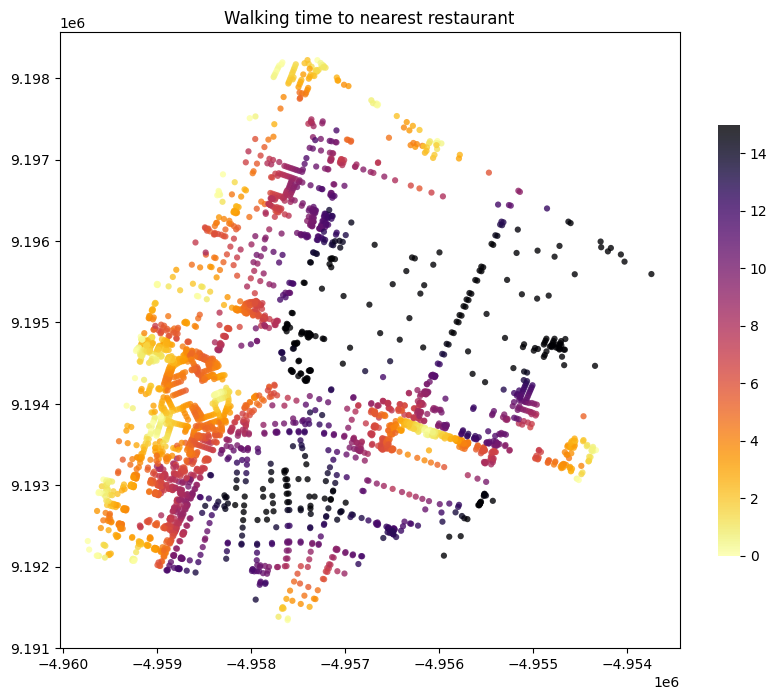

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot distance to nearest amenity from each node
# ox.plot_graph(G_walk_anjou, ax=ax, node_size=0, edge_linewidth=0.1,
#                         edge_color='gray', show=False, close=False)

nodes_anjou = pandana_anjou.nodes_df[['x', 'y']]

sc = ax.scatter(x=nodes_anjou['x'],
                y=nodes_anjou['y'], 
                c=distances_anjou['travel_time'], # column to plot (distance to nearest store)
                s=20, # size
                cmap='inferno_r',
                edgecolors='none',
                alpha=0.8)

ax.set_title('Walking time to nearest restaurant')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

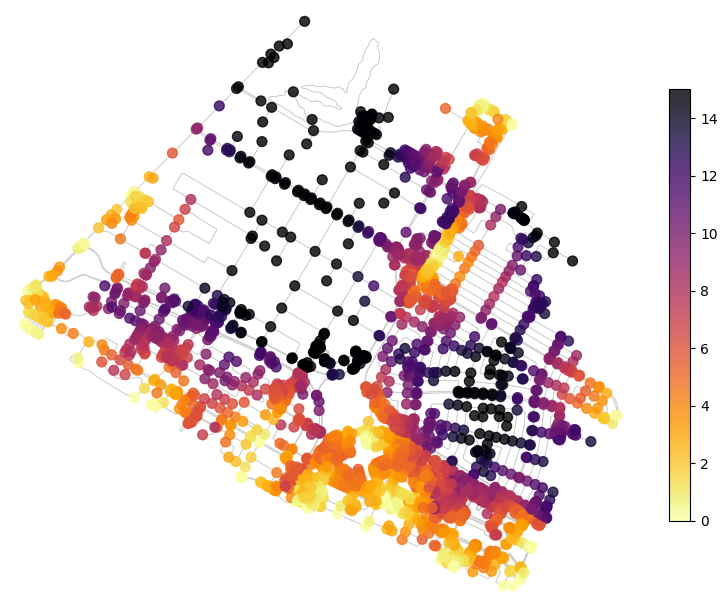

In [44]:
# this graph also has the right celestial projection (north on top)

G = ox.graph_from_place('Anjou, Montreal, Quebec, Canada', network_type='walk')

# Project the graph to an appropriate CRS
G_proj = ox.project_graph(G)

# Plot the graph with a light background
fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)

# Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

# Scatter plot on the same Axes instance
sc = ax.scatter(x=nodes_proj['x'], y=nodes_proj['y'], c=distances_anjou['travel_time'], s=50, cmap='inferno_r', alpha=0.8)

# Add colorbar
plt.colorbar(sc, ax=ax, shrink=0.7)

# Show the plot
plt.show()


In [14]:
G_walk_anjou

In [17]:
pandana_anjou.nodes_df['x']

osmid
224886238     -4.955472e+06
596644170     -4.955159e+06
4502353385    -4.955782e+06
224911443     -4.956666e+06
8875463868    -4.956651e+06
                   ...     
11662037419   -4.959223e+06
11662037462   -4.959074e+06
11662037420   -4.959213e+06
11662037457   -4.959072e+06
11662037426   -4.959254e+06
Name: x, Length: 3200, dtype: float64

In [18]:
pandana_anjou.nodes_df['y'],

(osmid
 224886238      9.196841e+06
 596644170      9.196618e+06
 4502353385     9.197060e+06
 224911443      9.197691e+06
 8875463868     9.197680e+06
                    ...     
 11662037419    9.193082e+06
 11662037462    9.193028e+06
 11662037420    9.193122e+06
 11662037457    9.193039e+06
 11662037426    9.193093e+06
 Name: y, Length: 3200, dtype: float64,)

In [45]:
distances_anjou['travel_time']

osmid
224886238      5.805000
596644170      9.130000
4502353385     2.526667
224911443      0.158333
8875463868     0.000000
                 ...   
11662037419    3.728333
11662037462    5.100000
11662037420    4.073333
11662037457    5.193333
11662037426    3.441667
Name: travel_time, Length: 3200, dtype: float64

In [22]:
len(distances_anjou)

3200

### Plotting with function - for app

**It would be nice, if we could just store the walking_distances, biking_distances, and driving_distances once as dfs. Then we can just throw them into the function as needed**

In [3]:
# store all graphs already
G_walk = ox.graph_from_place('Anjou, Montreal, Quebec, Canada', network_type='walk')
G_bike = ox.graph_from_place('Anjou, Montreal, Quebec, Canada', network_type='bike')
G_drive = ox.graph_from_place('Anjou, Montreal, Quebec, Canada', network_type='drive')

### WALKING DISTANCES

In [5]:
place = 'Montreal, Canada'
# Get all the "fresh food" stores on OSM within the study site
tags = {'amenity': ['restaurant', 'cafe']}
amenities = ox.features_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')
# Some amenities might be polygons, but we need them as points, so let's extract the centroids from the amenities' geometries
centroids = amenities.centroid

# graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs'
graphs_dir = '../graphs'

walk_graphs = {}
for file_name in tqdm(os.listdir(graphs_dir)):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_walk_neighborhood = ox.load_graphml(file_path)
        graphs[neighborhood] = G_walk_neighborhood
            

walk_pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in tqdm(graphs.items()):
    graph = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]
    
    network = pandana.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    pandanas[neighborhood] = network


walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx


walking_distances = {}
for neighborhood, pandana in tqdm(pandanas.items()):
    pandana.set_pois(category='restaurant', # amenity set here
                    maxdist=walk_time_sec,
                    maxitems=3,
                    x_col=centroids.x, 
                    y_col=centroids.y)
    
    distances = pandana.nearest_pois(distance=walk_time_sec,
                                    category='restaurant', # amenity set here
                                    num_pois=3)
    
    distances['travel_time'] = distances[1] / 60
    walking_distances[neighborhood] = distances
        
G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
pandana_anjou = pandanas['Anjou, Montreal, Canada'] # access one pandana network
walking_distances_anjou = walking_distances['Anjou, Montreal, Canada']

  6%|▌         | 1/18 [00:00<00:12,  1.40it/s]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 3382
Setting CH edge vector of size 10774
Range graph removed 10912 edges of 21548
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 11%|█         | 2/18 [00:03<00:30,  1.92s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 8890
Setting CH edge vector of size 29956
Range graph removed 30224 edges of 59912
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 17%|█▋        | 3/18 [00:07<00:43,  2.89s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 22%|██▏       | 4/18 [00:08<00:27,  1.95s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 3603
Setting CH edge vector of size 11218
Range graph removed 11360 edges of 22436
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 28%|██▊       | 5/18 [00:10<00:27,  2.15s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 12319
Setting CH edge vector of size 38440
Range graph removed 38976 edges of 76880
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 33%|███▎      | 6/18 [00:10<00:17,  1.49s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 1552
Setting CH edge vector of size 4430
Range graph removed 4700 edges of 8860
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 39%|███▉      | 7/18 [00:13<00:19,  1.78s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 9720
Setting CH edge vector of size 31244
Range graph removed 31622 edges of 62488
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 44%|████▍     | 8/18 [00:16<00:21,  2.18s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 13873
Setting CH edge vector of size 43952
Range graph removed 44518 edges of 87904
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 50%|█████     | 9/18 [00:17<00:18,  2.01s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 6417
Setting CH edge vector of size 20386
Range graph removed 20608 edges of 40772
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 56%|█████▌    | 10/18 [00:18<00:12,  1.54s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 3200
Setting CH edge vector of size 9782
Range graph removed 9918 edges of 19564
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 61%|██████    | 11/18 [00:18<00:07,  1.14s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 1441
Setting CH edge vector of size 4694
Range graph removed 4774 edges of 9388
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 67%|██████▋   | 12/18 [00:19<00:05,  1.05it/s]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 3795
Setting CH edge vector of size 11622
Range graph removed 11734 edges of 23244
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 72%|███████▏  | 13/18 [00:21<00:06,  1.39s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 9656
Setting CH edge vector of size 30874
Range graph removed 31136 edges of 61748
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 78%|███████▊  | 14/18 [00:24<00:07,  1.99s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 83%|████████▎ | 15/18 [00:28<00:07,  2.36s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 10410
Setting CH edge vector of size 33606
Range graph removed 33740 edges of 67212
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 89%|████████▉ | 16/18 [00:28<00:03,  1.84s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 94%|█████████▍| 17/18 [00:29<00:01,  1.47s/it]

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 3761
Setting CH edge vector of size 11500
Range graph removed 11874 edges of 23000
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [00:33<00:00,  1.84s/it]


Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 16731
Setting CH edge vector of size 55202
Range graph removed 55584 edges of 110404
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


100%|██████████| 18/18 [00:01<00:00, 13.04it/s]


### BIKING DISTANCES

In [21]:
# STILL NEED TO CHANGE THE TIMES DOWN HERE
bike_graphs = {}
for file_name in tqdm(os.listdir(graphs_dir)):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_bike_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_bike_neighborhood = ox.load_graphml(file_path)
        graphs[neighborhood] = G_bike_neighborhood
            

bike_pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in tqdm(graphs.items()):
    graph = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

    network = pandana.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    pandanas[neighborhood] = network

# CHANGE THE TIMES HERE

bike_time = 15  # max biking horizon in minutes
bike_speed = 5  # km per hour
bike_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx


biking_distances = {}
for neighborhood, pandana in tqdm(pandanas.items()):
    pandana.set_pois(category='restaurant', # amenity set here
                    maxdist=bike_time_sec,
                    maxitems=3,
                    x_col=centroids.x, 
                    y_col=centroids.y)
    
    distances = pandana.nearest_pois(distance=bike_time_sec,
                                    category='restaurant', # amenity set here
                                    num_pois=3)
    
    distances['travel_time'] = distances[1] / 60
    biking_distances[neighborhood] = distances
        
# G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
# pandana_anjou = pandanas['Anjou, Montreal, Canada'] # access one pandana network
biking_distances_anjou = biking_distances['Anjou, Montreal, Canada']

  0%|          | 0/36 [00:00<?, ?it/s]


AttributeError: 'Network' object has no attribute 'Network'

In [ ]:
# SAME NEEDED FOR DRIVING 

In [19]:
# function for plotting
def plot_neighborhood_graph(mode_of_transportation_graph, mode_of_transportation_distances, neighbourhood):
    # Load the graph from the specified place and network type
    G = mode_of_transportation_graph
    # CRS
    G_proj = ox.project_graph(G)
    
    distances = mode_of_transportation_distances[f"{neighbourhood}, Montreal, Canada"]
    
    # Plot the graph with a light background
    fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)
    
    # Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
    nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
    
    # Scatter plot on the same Axes instance
    sc = ax.scatter(x=nodes_proj["x"], y=nodes_proj["y"], c=distances['travel_time'], s=50, cmap='inferno_r', alpha=0.8)
    
    # Add colorbar
    plt.colorbar(sc, ax=ax, shrink=0.7)
    
    # Show the plot
    plt.show()

# example usage
# plot_neighborhood_graph(G_walk_anjou, 'Anjou')

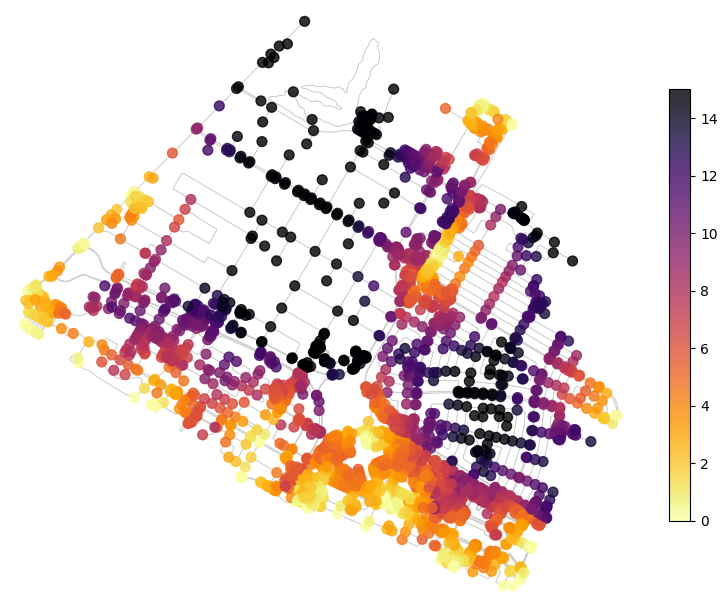

In [20]:
plot_neighborhood_graph(G_walk_anjou, 'Anjou')